### Load necessary library and build helpful functions

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle

# Helpful functions

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient   
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobely = np.absolute(sobely)
    abs_sobelx = np.absolute(sobelx)
    dir = np.arctan2(abs_sobely, abs_sobelx)
    
    dir_binary = np.zeros_like(dir)
    dir_binary[(dir > thresh[0]) & (dir < thresh[1])] = 1
    return dir_binary

def binary(img, s_thresh=(140, 255), ksize = 3):
    img = np.copy(img)
    R = img[:,:,0]
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    S = hls[:,:,2]
    
    # Gradient
    gradx = abs_sobel_thresh(R, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(R, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(R, sobel_kernel=ksize, thresh=(0.7, 1.3))
    gradient = np.zeros_like(dir_binary)
    gradient[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # Combine binaries
    combined_binary = np.zeros_like(gradient)
    combined_binary[(s_binary == 1) | (gradient == 1)] = 1
    
    return combined_binary

In [3]:
#Load saved cameral calibration and distortion coefficients
dist_pickle = pickle.load(open("./cal_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

## Apply calculated cc and dc to distort a chessboard image

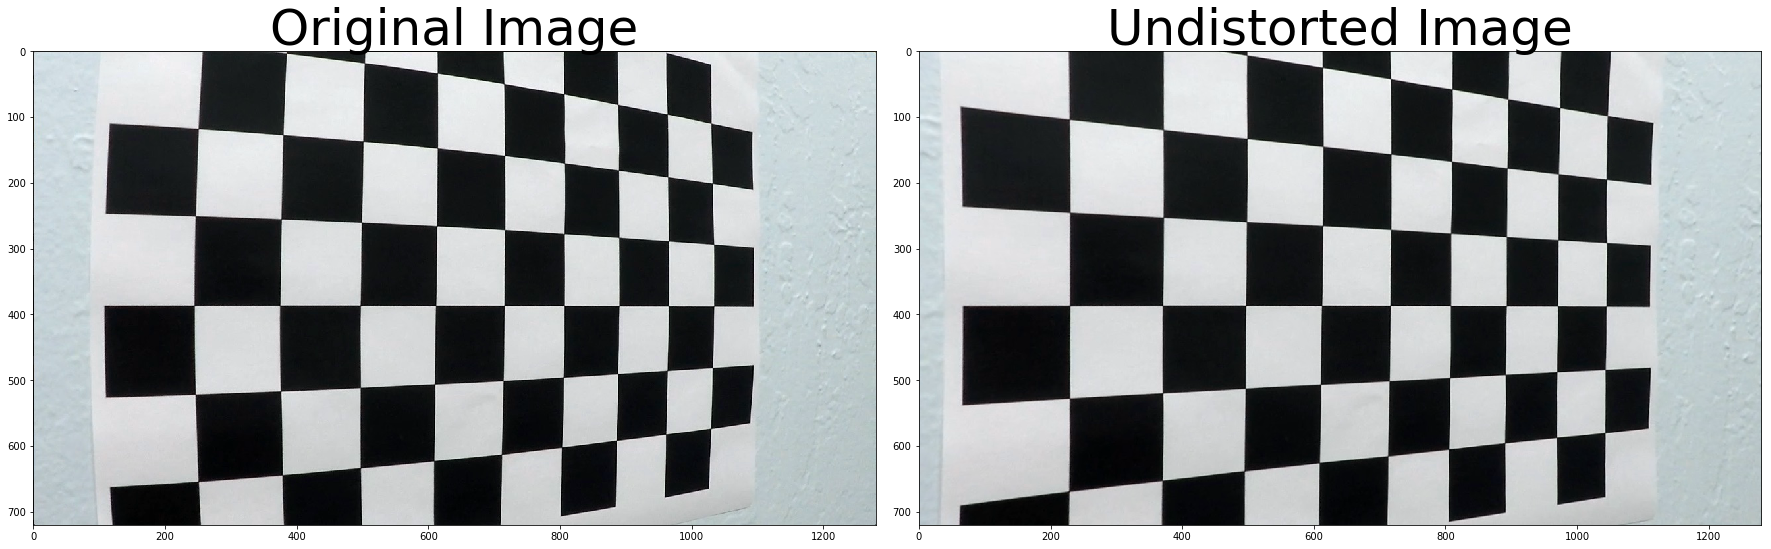

In [24]:
%matplotlib inline
# Undistort a chessboard image save it
cal5 = cv2.imread('camera_cal/calibration5.jpg')
cal5_undist = cv2.undistort(cal5, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal5)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cal5_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("output_images/01.calibration.jpg")

## Apply same camera calibration to distort a test image

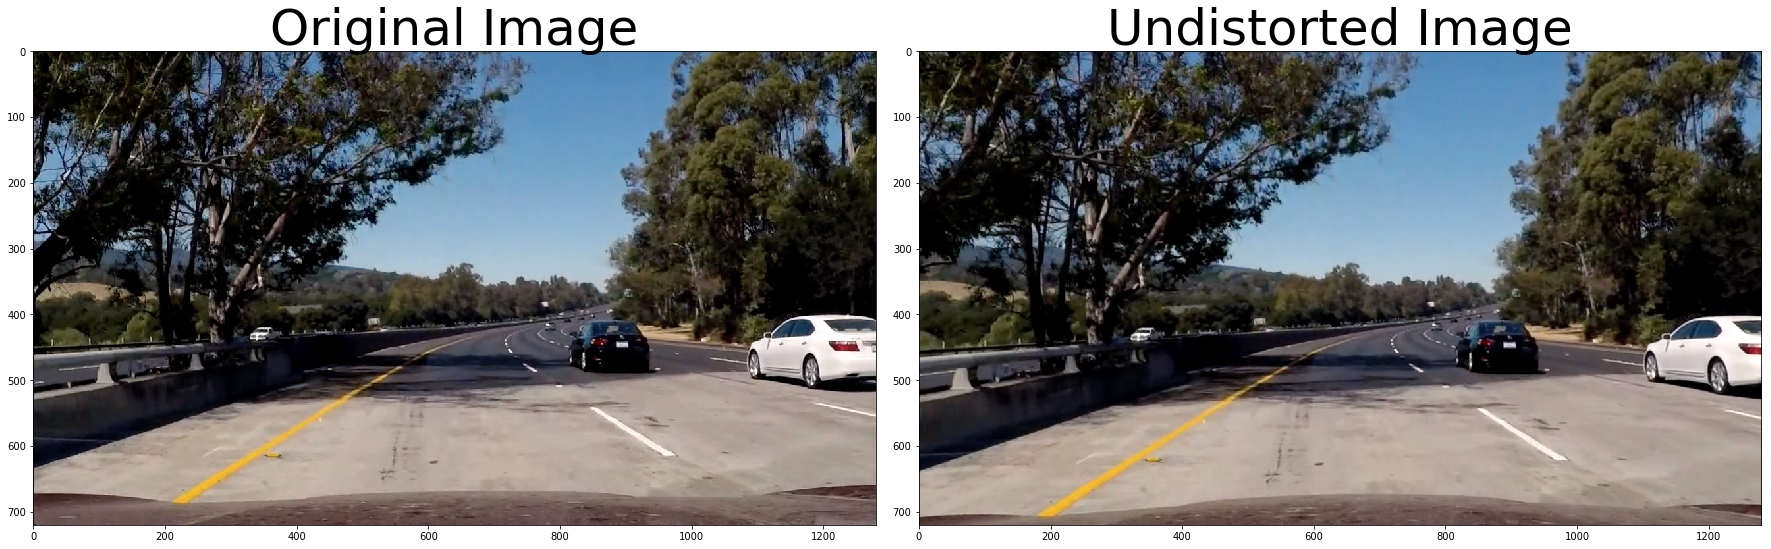

In [26]:
test4 = mpimg.imread("test_images/test5.jpg")
test4_undist = cv2.undistort(test4, mtx, dist, None, mtx)

#plt.imshow(undist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test4)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test4_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("output_images/02.undistortion.jpg")

## Combined colour and gradient threshold to a test image

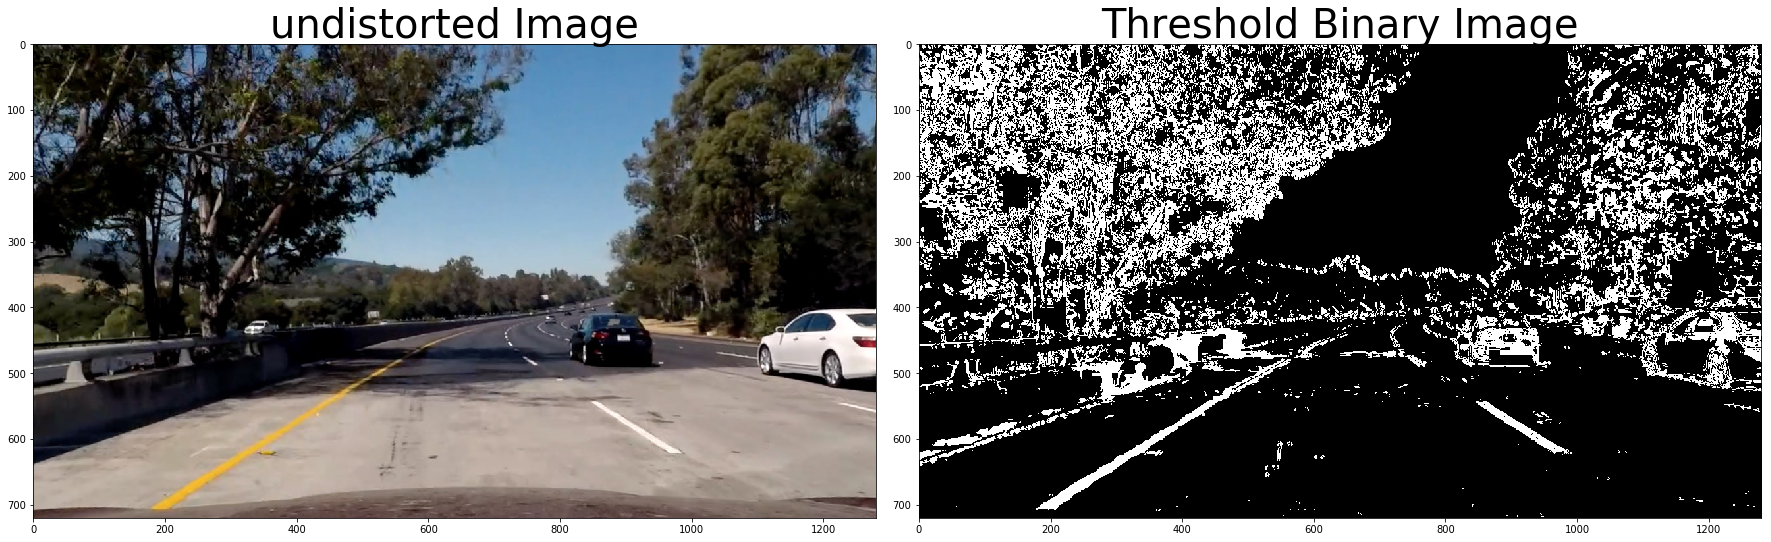

In [27]:
threshold = binary(test4_undist, ksize = 11)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test4_undist)
ax1.set_title('undistorted Image', fontsize=40)
ax2.imshow(threshold, cmap='gray')
ax2.set_title('Threshold Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("output_images/03.binary.jpg")

## Transform image to a bird-eye perspective

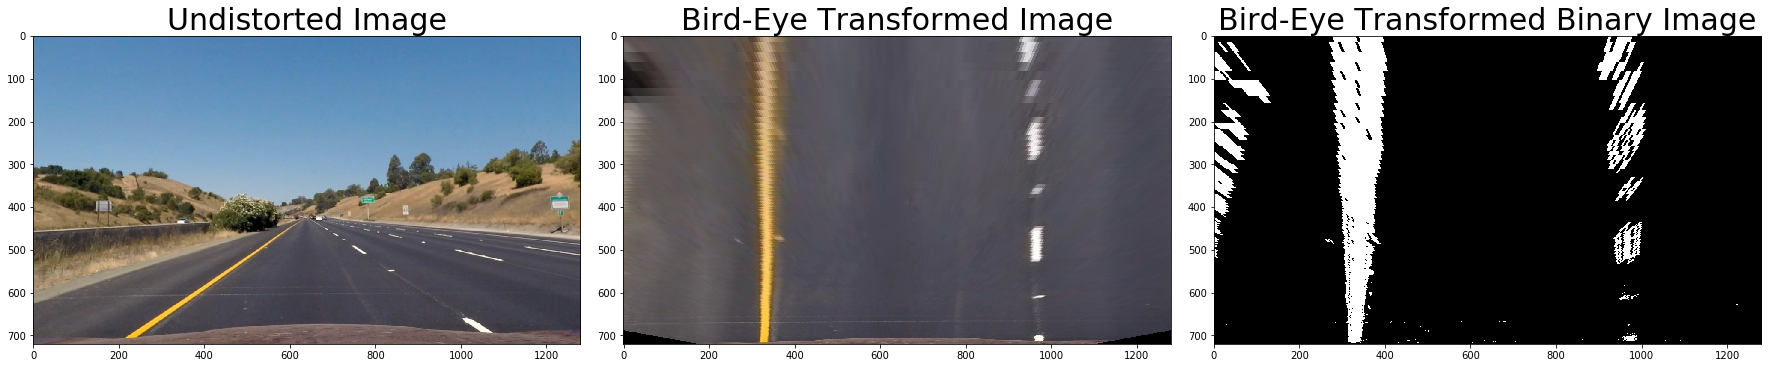

In [31]:
## Load and preprocess a straight line image to transform perspective
straight = mpimg.imread("test_images/straight_lines1.jpg")
straight_undist = cv2.undistort(straight, mtx, dist, None, mtx)  
straight_binary = binary(straight_undist, ksize = 11)

img_size = (straight_undist.shape[1], straight_undist.shape[0])   

src = np.float32(
     [[(img_size[0] / 2) - 46, (img_size[1] / 2) + 90],
     [((img_size[0] / 6) - 20), (img_size[1])],
     [(img_size[0] * 5 / 6) + 20, img_size[1]],
     [(img_size[0] / 2 + 46), img_size[1] / 2 + 90]])
dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped_undist = cv2.warpPerspective(straight_undist, M, img_size, flags=cv2.INTER_NEAREST)  
warped_binary = cv2.warpPerspective(straight_binary, M, img_size, flags=cv2.INTER_NEAREST)  
warped = cv2.warpPerspective(threshold, M, img_size, flags=cv2.INTER_NEAREST)  

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(straight_undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped_undist, cmap='gray')
ax2.set_title('Bird-Eye Transformed Image', fontsize=30)
ax3.imshow(warped_binary, cmap='gray')
ax3.set_title('Bird-Eye Transformed Binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("output_images/04.perspective_transform.jpg")

## Find lane-line by sliding window

In [32]:
# Take a histogram of the bottom half of the image
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = (np.dstack((warped, warped, warped))*255.999).astype(np.uint8)
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 60
# Set minimum number of pixels found to recenter window
minpix = 100
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

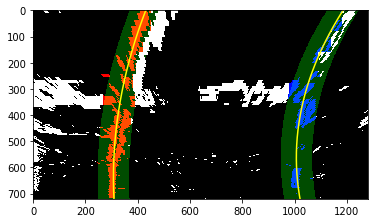

In [34]:
# Create an image to draw on and an image to show the selection window
out_img = (np.dstack((warped, warped, warped))*255.999).astype(np.uint8)
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig("output_images/05.draw_lane_warped.jpg")

## Calculate radius of curvature and the car position

In [36]:
# Choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

544.364228727 m 291.96324837 m


In [38]:
# Calculate the car position
## Assumption: the cameral is in the centre of the car
cameral_centre = (left_fitx[-1] + right_fitx[-1])/2
centre_diff = (cameral_centre-warped.shape[1]/2)*xm_per_pix
side = 'left'
if centre_diff <= 0:
    side = 'right'
print(centre_diff, 'm')

0.130828876474 m


## Draw the lines on the original image

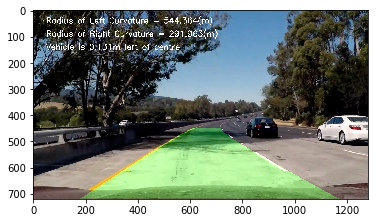

In [42]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
# Combine the result with the original image
result = cv2.addWeighted(test4, 1, newwarp, 0.3, 0)

# Draw radius and position texts on the image
cv2.putText(result, 'Radius of Left Curvature = '+str(round(left_curverad, 3))+'(m)', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255),2)
cv2.putText(result, 'Radius of Right Curvature = '+str(round(right_curverad, 3))+'(m)', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255),2)
cv2.putText(result, 'Vehicle is '+str(abs(round(centre_diff, 3)))+'m '+side+' of centre',(50,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255),2)

plt.imshow(result)
plt.savefig('output_images/06.result.jpg')